In [24]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from collections import Counter
import pickle

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
nltk.download('vader_lexicon')
BigramAssocMeasures = nltk.collocations.BigramAssocMeasures()
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

from tqdm import tqdm
tqdm.pandas()

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cgottorff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cgottorff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/cgottorff/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cgottorff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
NEWS_PATH = Path.cwd() / "data" / "health.jsonl"
NEWS_FILE = NEWS_PATH.open()

news = pd.DataFrame(json.loads(line) for line in NEWS_FILE)
city_health = pd.read_csv('data/city_health_data.csv',index_col=0)

for i in range(len(city_health['url'])): 
    if 'http://' in city_health['url'][i]: 
        city_health['url'][i] = city_health['url'][i].replace('http://', '')
    if 'www.' in city_health['url'][i]: 
        city_health['url'][i]  = city_health['url'][i].replace('www.', '')


#filtering for american news from city_health dataset       
news_local = news[news['domain'].isin(list(city_health['url']))]

#news_local.to_csv('local_news.csv') #saving to csv
#city_health.to_csv('data/city_health_data.csv') #saving to csv

In [3]:
#loading health articles from local news

news_local = pd.read_csv('data/local_news.csv', index_col=0).reset_index(drop=True)

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_20212/3580370825.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  news_local = pd.read_csv('data/local_news.csv', index_col=0).reset_index(drop=True)


In [3]:
news_local.head()

,url,url_used,title,text,summary,authors,publish_date,domain,warc_date,status,split
0,http://www.washingtonpost.com/news/act-four/wp...,https://web.archive.org/web/2014052819id_/http...,Ann Hornaday v. Judd Apatow and how culture sh...,"On Sunday, shortly removed from the Friday nig...",The comedy director lashed out at the Washingt...,"['Alyssa Rosenberg', 'Adam Taylor']",05-28-2014,washingtonpost.com,2014052819,success_wayback,train
1,http://www.washingtonpost.com/blogs/plum-line/...,https://web.archive.org/web/2013122419id_/http...,Sen. Joe Manchin’s misreading of gun control p...,Senator Joe Manchin did an laudable job this y...,Even though his post-Newtown push for a new la...,"['Jessica Stahl', 'Michael Livingston Ii', 'Da...",12-23-2013,washingtonpost.com,2013122419,success_wayback,train
2,http://www.washingtonpost.com/blogs/she-the-pe...,https://web.archive.org/web/2014050919id_/http...,"In North Carolina, Rand Paul touts tea party d...","CHARLOTTE — Earlier this week, Rand Paul was s...",The Kentucky senator could not pull his guy ov...,"['Mary C. Curtis', 'Wesley Lowery', 'Adam Tayl...",05-09-2014,washingtonpost.com,2014050919,success_wayback,train
3,http://www.washingtonpost.com/blogs/the-fix/wp...,https://web.archive.org/web/2013111119id_/http...,Democrats are looking to expand the 2014 House...,House Democratic strategists are aggressively ...,House Democrats are looking to compete in dist...,['Sean Sullivan'],11-11-2013,washingtonpost.com,2013111119,success_wayback,train
4,http://www.nydailynews.com/news/national/bobby...,https://web.archive.org/web/2015080319id_/http...,Bobby Brown's wife Alicia Etheredge suffers se...,Being Bobby Brown isn’t getting any easier.\nJ...,Bobby Brown's emotional day has somehow gotten...,"['Joseph Barracato', 'Joel Landau', 'Leonard G...",08-02-2015,nydailynews.com,2015080319,success_wayback,train


In [4]:
print(len(set(news_local['domain']))) #number of news orgs in dataset 
print(len(news_local)) # number of articles in dataset
print(news_local.describe())

29
278115
                                                      url  \
count                                              278115   
unique                                             278115   
top     http://www.washingtonpost.com/news/act-four/wp...   
freq                                                    1   

                                                 url_used  \
count                                                 461   
unique                                                461   
top     https://web.archive.org/web/2014052819id_/http...   
freq                                                    1   

                                    title  \
count                              278115   
unique                             270409   
top     Anne Arundel County health briefs   
freq                                   57   

                                                     text  \
count                                              278115   
unique                        

In [5]:
#turning publish date to datetime
for i in range(len(news_local['publish_date'])):
    try:
        news_local['publish_date'][i] =  datetime_object = datetime.strptime(news_local['publish_date'][i], '%m-%d-%Y')
    except ValueError:
        news_local['publish_date'][i] = np.nan

print(len([i for i in news_local['publish_date'] if type(i) != datetime]))
news_local = news_local[news_local['publish_date'].notna()] #droping the ~60 articles with no valid publish date

61


37


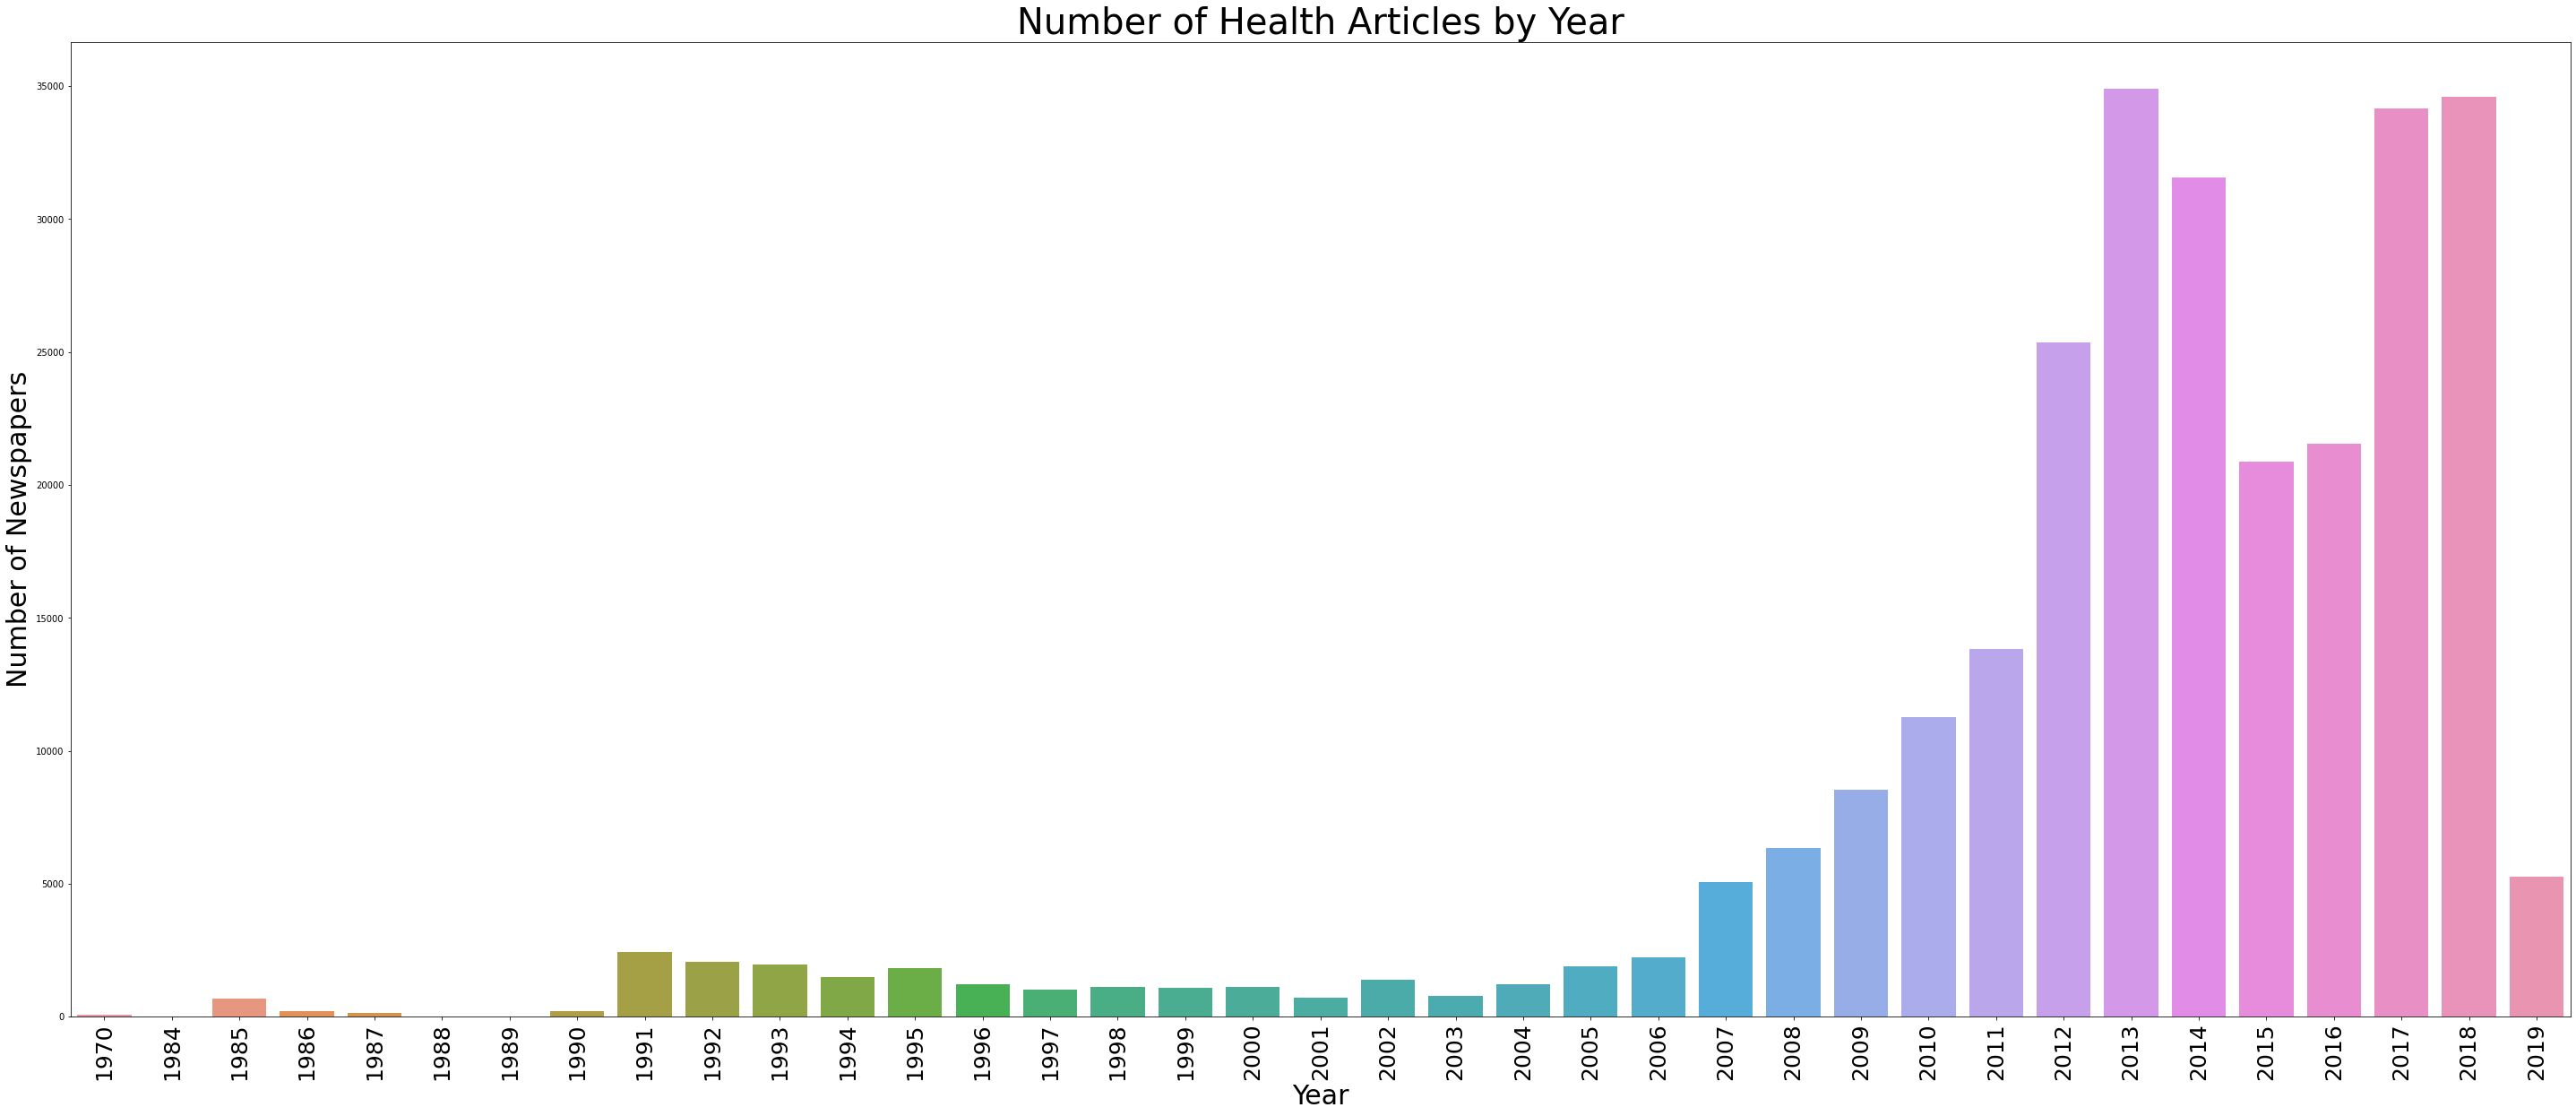

In [5]:
# news in dataset by year
years = [i.year for i in news_local['publish_date']]
year_count = Counter(years)
keys = list(year_count.keys())
vals = [int(year_count[k]) for k in keys]

#how many years are in the list
print(len(year_count))

#bar chart of the number of newspapers in each city
plt.figure(figsize=(50,20))
plot = sns.barplot(x=keys, y=vals)
plt.setp(plot.get_xticklabels(), rotation=90, fontsize=25)
plt.title('Number of Health Articles by Year', fontsize=40)
plt.xlabel('Year', fontsize=30)
plt.ylabel('Number of Newspapers', fontsize=30)
plt.savefig('health_articles_per_year.pdf')

In [6]:
#removing articles published before 2009
max_date = datetime(2009,1,1)
news_local = news_local[news_local['publish_date'] > max_date]
news_local = news_local.reset_index(drop=True)

Natural Language Processing of Articles

In [7]:
#cleaning text
def clean_text(text):
    text = text.replace('\n', ' ').replace('\r', '')#removing new lines
    text = text.replace('\t', ' ')#removing tabs
    text = text.replace('  ', ' ')#removing double spaces
    text = text.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')) #removing all punctuation
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if len(token) > 2] #removing short words
    tokens = [token for token in tokens if token not in stopwords.words('english')] #removing stopwords
    return tokens

news_local['clean_text'] = news_local['text'].progress_apply(clean_text)


100%|██████████| 241806/241806 [4:56:10<00:00, 13.61it/s]   


In [9]:
#saving news_local to parquet to save datatypes
news_local.to_parquet('data/news_local_cleaned.parquet')

In [19]:
#adding number of times health is mentioned in each article
news_local['health_count'] = [article.count('health') for article in tqdm(news_local['clean_text'])]

100%|██████████| 241806/241806 [00:23<00:00, 10330.04it/s]


In [20]:
#creating variable for list of top 10 words in each health article
def get_top_words(tokens, n=10):
    freq = nltk.FreqDist(tokens)
    com = freq.most_common(n)
    words = [words[0] for words in com]
    return words
    
#health_news['top_words'] = health_news['clean_text'].apply(get_top_words)
#health_news['top_words'] = [i[0] for words in health_news['top_words'] for i in words]

news_local['top_words'] = news_local['clean_text'].progress_apply(get_top_words)

100%|██████████| 241806/241806 [01:42<00:00, 2355.10it/s]


In [234]:
#creating bigrams for each article

def get_bigrams(tokens, n=10):
    #tokens = [stemmer.stem(word) for word in tokens] #stemming words
    tokens = [lemmatizer.lemmatize(word) for word in tokens] #lemmatizing words
    bigram_finder = nltk.BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.nbest(BigramAssocMeasures.mi_like, n) #10 most informative bigrams by mutual information
    bigram_mi = []
    for bigram_tuple in bigrams:
            x = "%s_%s" % bigram_tuple
            bigram_mi.append(x)
    return bigram_mi

news_local['bigrams'] = news_local['clean_text'].progress_apply(get_bigrams)

100%|██████████| 241806/241806 [11:54<00:00, 338.30it/s]


In [23]:
#sentiment analysis of each article
sid = SentimentIntensityAnalyzer()
def get_sentiment(text):
    compound_score = sid.polarity_scores(text)['compound']
    return compound_score

news_local['sentiment'] = news_local['text'].progress_apply(get_sentiment)

100%|██████████| 241806/241806 [31:33<00:00, 127.70it/s]


In [24]:
#saving news_local to csv
news_local.to_parquet('data/news_local_cleaned.parquet')

In [73]:
clean_articles = news_local['clean_text'].apply(lambda x: " ".join(x))
all_text = " ".join(article for article in clean_articles)

#most frequent words in all article text
all_com_words = get_top_words(all_text.split(), n=100)
print ("The top 100 most frequent words accross all health articles are: {}".format(all_com_words))

#most important bigrams by mutual information
all_bis = get_bigrams(all_text.split(), n=100)
print ("The 100 most informative bigrams by mutual information accross all health articles are: {}".format(all_bis))

The top 100 most frequent words accross all health articles are: ['said', 'health', 'one', 'would', 'new', 'state', 'people', 'also', 'year', 'years', 'time', 'get', 'two', 'last', 'first', 'like', 'percent', 'could', 'care', 'school', 'county', 'city', 'back', 'make', 'many', 'going', 'season', 'center', 'million', 'good', 'work', 'even', 'public', 'day', 'game', 'three', 'team', 'may', 'way', 'help', 'president', 'still', 'much', 'week', 'think', 'home', 'community', 'well', 'take', 'need', 'since', 'says', 'know', 'medical', 'children', 'program', 'see', 'made', 'want', 'family', 'high', 'right', 'say', 'according', 'including', 'house', 'next', 'long', 'department', 'services', 'every', 'part', 'another', 'law', 'federal', 'play', 'healthy', 'really', 'life', 'better', 'best', 'students', 'university', 'lot', 'got', 'government', 'four', 'california', 'group', 'states', 'officials', 'use', 'money', 'food', 'around', 'national', 'business', 'hospital', 'come', 'end']
The 100 most in

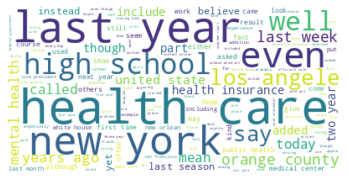

In [25]:
#word cloud of all articles text
wordcloud = WordCloud(background_color="white").generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('wordcloud.pdf')

Topic Modeling

In [3]:
#reading in news_local_cleaned with nlp columns
news_local  = pd.read_parquet('data/news_local_cleaned.parquet')

/var/folders/fc/vhrg50qd74x2j3j9gbnl92140000gn/T/ipykernel_20071/1719145287.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  news_local  = pd.read_csv('data/news_local_cleaned.csv')


There are 735029662 words in the combination of all articles


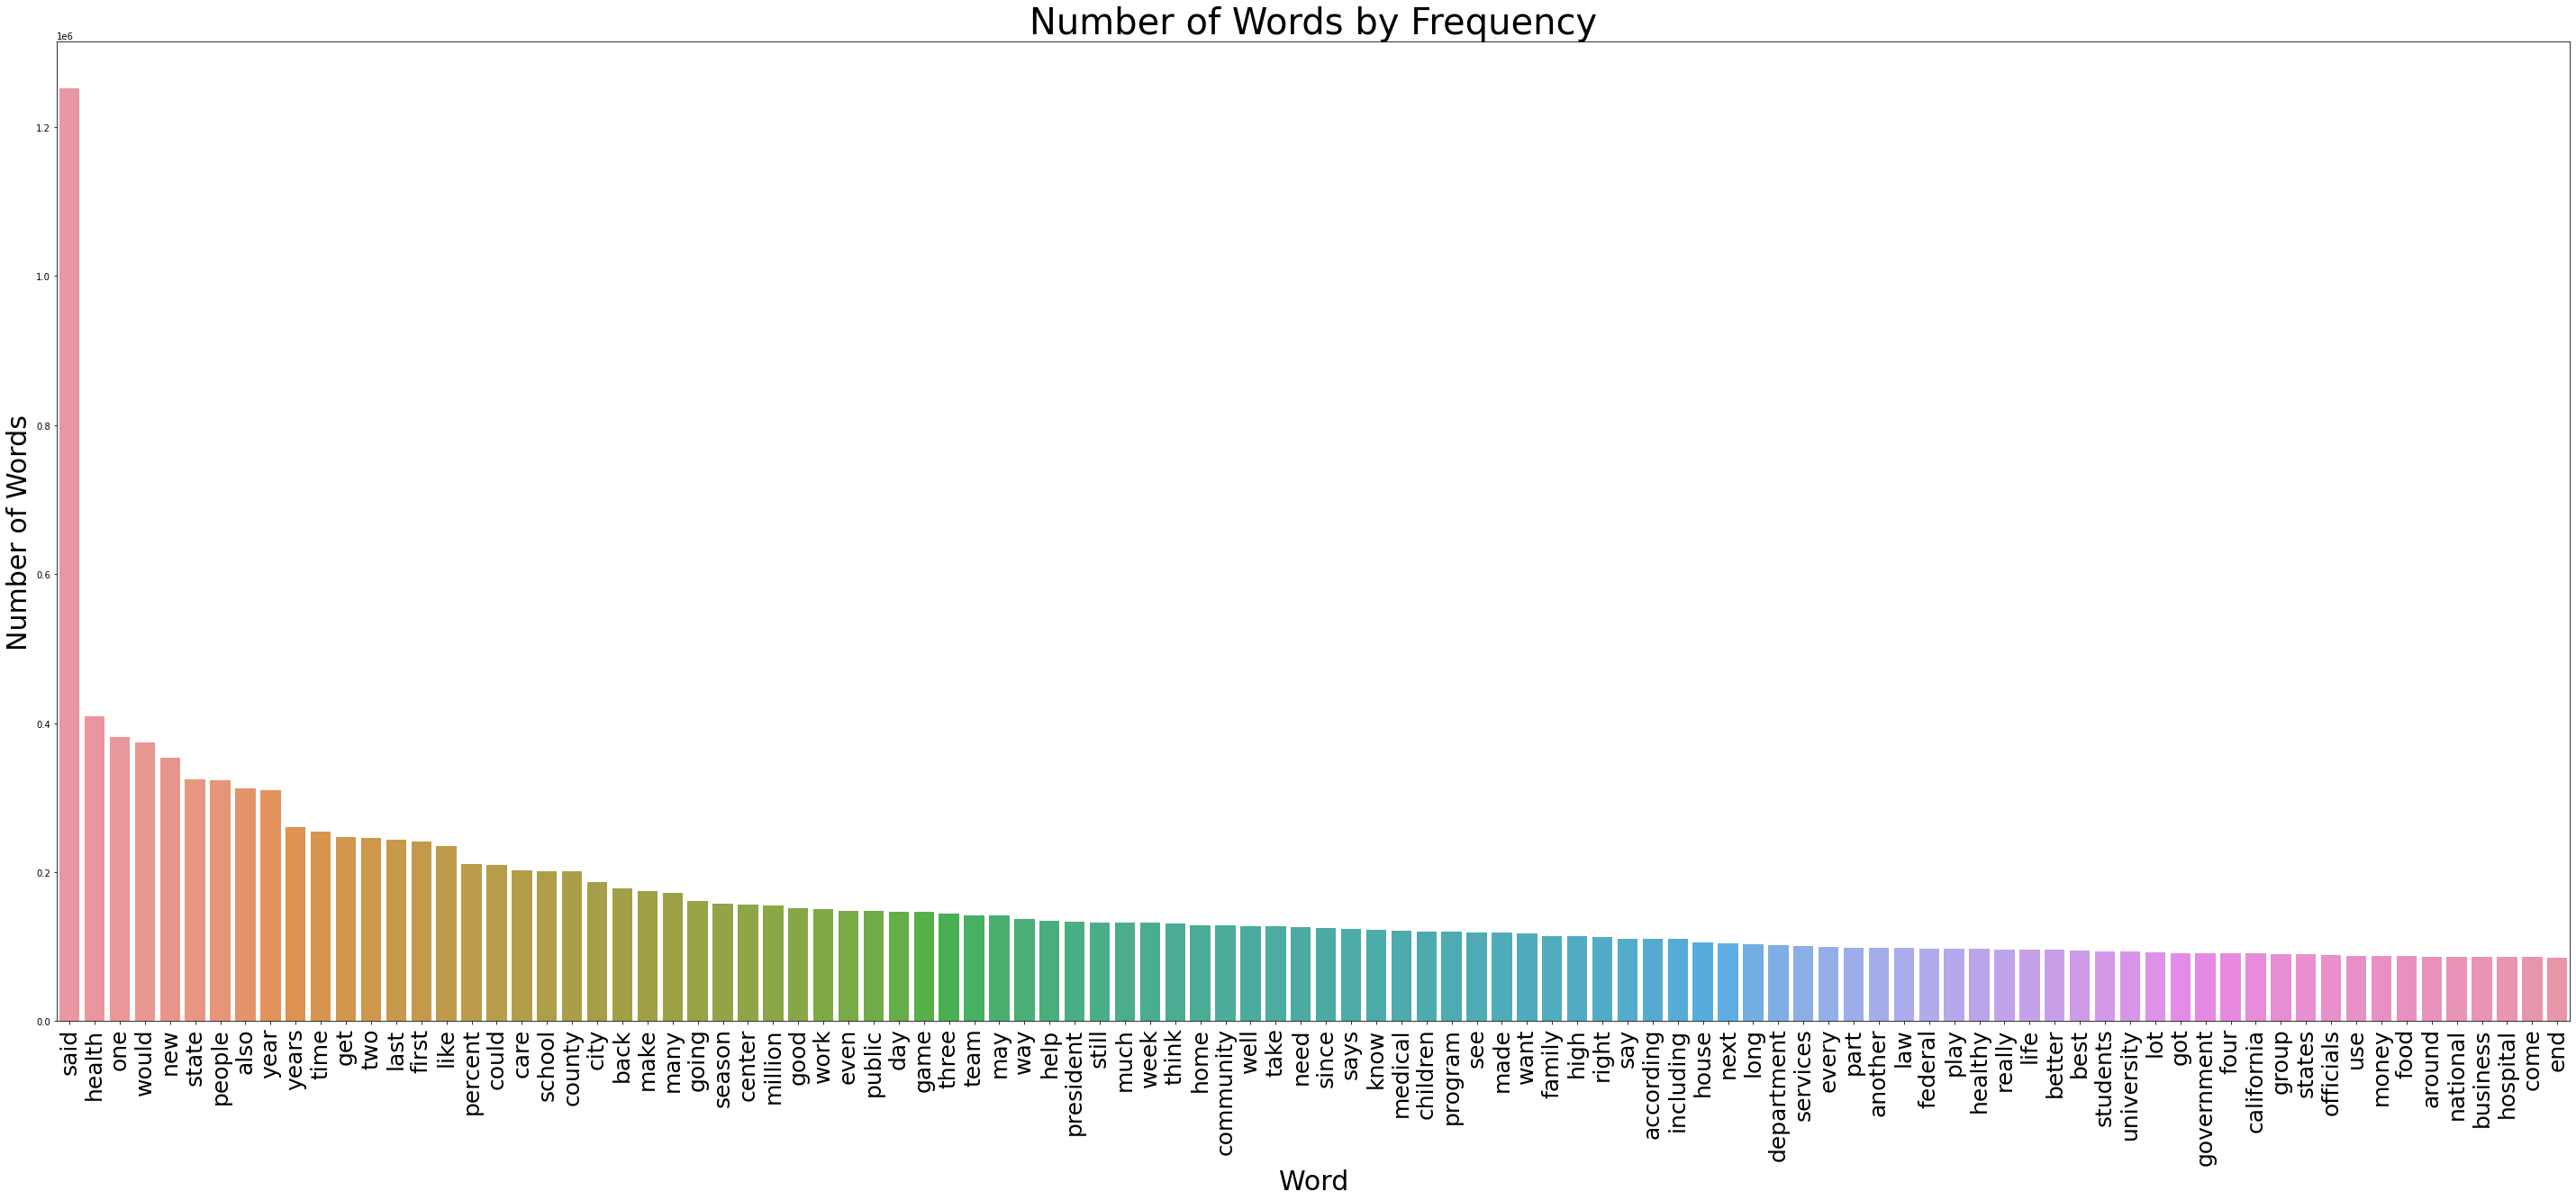

In [28]:
clean_articles = news_local['clean_text'].apply(lambda x: " ".join(x))
all_text = " ".join(article for article in clean_articles)

print ("There are {} words in the combination of all articles".format(len(all_text)))

word_freq = Counter(all_text.split())
word_freq = {k: v for k, v in sorted(word_freq.items(), reverse=True, key=lambda item: item[1])}

#most frequent 500 words
keys = list(word_freq.keys())[0:100]
vals = [int(word_freq[k]) for k in keys][0:100]

#bar chart of the number of words by frequency
plt.figure(figsize=(50,20))
plot = sns.barplot(x=keys, y=vals)
plt.setp(plot.get_xticklabels(), rotation=90, fontsize=25)
plt.title('Number of Words by Frequency', fontsize=40)
plt.xlabel('Word', fontsize=30)
plt.ylabel('Number of Words', fontsize=30)
plt.savefig('health_articles_word_freq.pdf')

In [166]:
#creating brigrams based on whole text and incorporating them into clean text
# Build the bigram model
bigram = gensim.models.Phrases(news_local['clean_text'], min_count=10, threshold=500) #parameters based on word frequency
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [167]:
#saving bigram model
bigram_mod.save('data/bigram_model.pkl')
#saving news_local to csv
news_local.to_parquet('data/news_local_cleaned.parquet')

In [170]:
#applying model to whole dataframe
def make_bigrams(text):
    return bigram_mod[text]

news_local['clean_bigrams'] = news_local['clean_text'].progress_apply(make_bigrams)

100%|██████████| 241806/241806 [01:56<00:00, 2068.70it/s]


In [171]:
#saving to csv
news_local.to_parquet('data/news_local_cleaned.parquet')

In [172]:
# Create Dictionary
id2word = corpora.Dictionary(news_local['clean_bigrams'])
# Create Corpus
texts = news_local['clean_bigrams']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [175]:
num_topics = [2, 4, 8, 16, 32] #we will not be looking at 32, late will be thrown out
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(corpus),
                             passes=3,
                             alpha='auto',
                             random_state=8)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|██████████| 5/5 [2:42:39<00:00, 1951.87s/it]


In [ ]:
#saving LDA models and topics
with open('lda_models.pkl', 'wb') as f:
    pickle.dump(LDA_models, f)
with open('lda_topics.pkl', 'wb') as f:
    pickle.dump(LDA_topics, f)

In [176]:
def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [177]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [179]:
coherence = [CoherenceModel(model=LDA_models[i], texts=texts, dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [180]:
coh_sta_diffs = [coherence[i] - mean_stabilities[i] for i in range(len(coherence))]
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

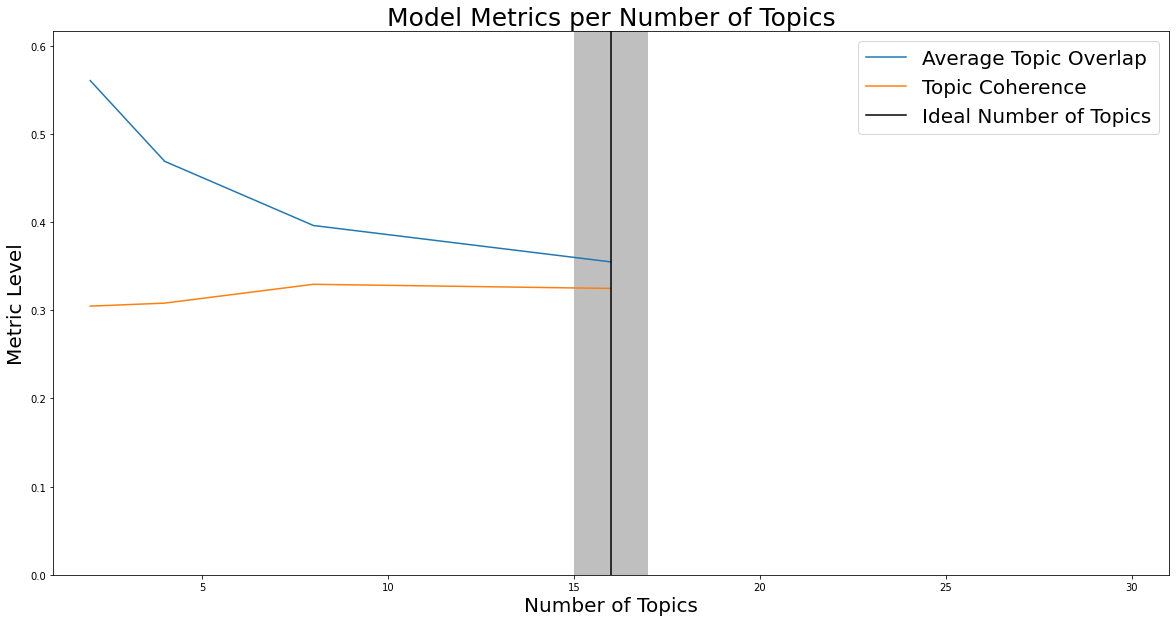

In [182]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherence, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherence)) + (0.10 * max(max(mean_stabilities), max(coherence)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [196]:
#running LDA on 16 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(LDA_models[16], corpus, id2word)
vis

/Users/cgottorff/Documents/ddgmtn/.env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/cgottorff/Documents/ddgmtn/.env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cgottorff/Documents/ddgmtn/.env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cgottorff/Documents/ddgmtn/.env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.114536  0.071963       1        1  16.867222
13    -0.064787  0.014285       2        1  10.939990
0     -0.063619  0.016906       3        1   9.282677
5     -0.061132  0.003879       4        1   9.039076
10     0.038097 -0.061510       5        1   8.959416
1     -0.034702 -0.008879       6        1   8.537173
6      0.014192  0.020225       7        1   6.176853
12    -0.003055  0.019739       8        1   5.922279
8      0.019657 -0.021994       9        1   4.920192
7     -0.018836  0.013503      10        1   4.386772
3      0.026429 -0.087155      11        1   4.263488
2      0.049053 -0.036393      12        1   3.409079
14    -0.031782 -0.004625      13        1   3.173209
4     -0.006572  0.019857      14        1   2.450675
15    -0.008314  0.017279      15        1   1.194287
9      0.030835  0.022919      16        1   0.477612, topic_info=        Term          Freq         Total Category  logprob  loglift
752     said  1.235990e+06  1.235990e+06  Default  30.0000  30.0000
680   health  3.945890e+05  3.945890e+05  Default  29.0000  29.0000
767    state  3.137420e+05  3.137420e+05  Default  28.0000  28.0000
607    would  3.676310e+05  3.676310e+05  Default  27.0000  27.0000
383      new  3.561760e+05  3.561760e+05  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1072   three  7.151860e+02  1.490333e+05  Topic16  -6.4808   0.0047
777     take  6.982503e+02  1.298090e+05  Topic16  -6.5048   0.1189
1542     get  7.460417e+02  2.458311e+05  Topic16  -6.4386  -0.4535
672    going  7.082248e+02  1.630281e+05  Topic16  -6.4906  -0.0948
712      may  6.817051e+02  1.442313e+05  Topic16  -6.5287  -0.0105

[1793 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
7255       1  0.168097   000
7255       2  0.039398   000
7255       3  0.055157   000
7255       4  0.026265   000
7255       5  0.007880   000
...      ...       ...   ...
11519     12  0.015587  zika
11519     13  0.493213  zika
11519     14  0.024494  zika
11519     15  0.006309  zika
11519     16  0.000371  zika

[15846 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 1, 6, 11, 2, 7, 13, 9, 8, 4, 3, 15, 5, 16, 10])

In [197]:
#saving LDA chart to webpage
pyLDAvis.save_html(vis, 'health_lda.html')

In [227]:
#applying LDA to whole dataframe
lda_model = LDA_models[16]
lda_corpus = lda_model[corpus]
topics_score = [max(prob,key=lambda y:y[1]) for prob in lda_corpus]
topics = [key for key,value in topics_score]
news_local['topics'] = topics

In [228]:
#saving to parquet
news_local.to_parquet('data/news_local_cleaned.parquet')